In [1]:
# Description:
#   Exercise5 notebook.
#
# Copyright (C) 2018 Santiago Cortes, Juha Ylioinas
#
# This software is distributed under the GNU General Public 
# Licence (version 2 or later); please refer to the file 
# Licence.txt, included with the software, for details.

# Preparations
import numpy as np
import matplotlib.pyplot as plt
import cv2

# CS-E4850 Computer Vision Exercise Round 5¶

## Robust line fitting using RANSAC.

Run the example script robustLineFitting, which plots a set of points $(x_i,y_i), i=1,\ldots,n$, and estimate a line that best fits to these points by implementing a RANSAC approach as explained in the slides of Lecture 4:


Repeat the following steps $N$ times (set $N$ large enough according to the guidelines given in the lecture):

- Draw 2 points uniformly at random from set $(x_i,y_i)$.

- Fit a line to these 2 points.

- Determine the inliers to this line among the remaining points (i.e.\ points whose distance to the line is less
than a suitably set threshold $t$).


Take the line with most inliers from previous stage and refit it using total least squares fitting to all inliers.
Plot the estimated line and all the points $(x_i,y_i)$ to the same figure and report the estimated values of the line's coefficients.


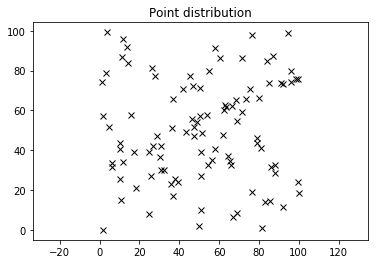

In [2]:
# Load and plot points
data = np.load('points.npy')
x, y = data[0,:], data[1,:]
plt.plot(x, y, 'kx')
plt.title('Point distribution')
plt.axis('equal')
plt.show()

# there are 100 points

In [3]:
def choose_pair():
    indexes = np.random.randint(low=0, high=99, size=2)
    if indexes[0] == indexes[1]:
        return choose_pair()
    else:
        return indexes

In [4]:
N = 300
t = 5

most_inlier = 0
coeff = 0, 0

for _ in range(N):
    i1, i2 = choose_pair()
    x1, y1 = x[i1], y[i1]
    x2, y2 = x[i2], y[i2]
    
    x_coords = x1, x2
    y_coords = y1, y2
    
    m, b = np.polyfit(x=x_coords, y=y_coords, deg=1)
    inlier = 0
    for other_i in range(len(x)):
        if other_i not in (i1, i2):
            x_p, y_p = x[other_i], y[other_i] 
            distance = np.abs(-m*x_p + y_p -b)
            if distance <= t:
                inlier += 1
    
    if inlier > most_inlier:
        most_inlier = inlier
        coeff = m, b
        
print(most_inlier)
print(coeff)

29
(0.4893532838307336, 28.47118001472204)


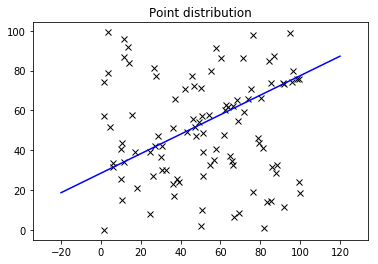

In [5]:
# Load and plot points
data = np.load('points.npy')
x, y = data[0,:], data[1,:]
plt.plot(x, y, 'kx')
plt.title('Point distribution')
plt.axis('equal')

p = np.linspace(-20.,120.)
plt.plot(p, coeff[0]*p+coeff[1], 'b')

plt.show()

### Refitting using all inliers

In [6]:
m, b = coeff

In [7]:
x_coords = []
y_coords = []

for i in range(len(x)):
    x_i, y_i = x[i], y[i]
    distance = np.abs(-m*x_i + y_i -b)
    if distance <= t:
        x_coords.append(x_i)
        y_coords.append(y_i)

m_new, b_new = np.polyfit(x=x_coords, y=y_coords, deg=1)

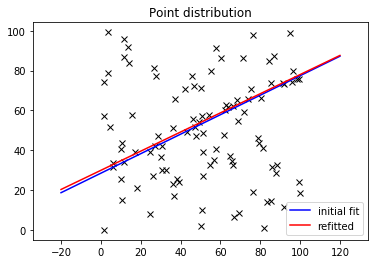

In [8]:
# Load and plot points
data = np.load('points.npy')
x, y = data[0,:], data[1,:]
plt.plot(x, y, 'kx')
plt.title('Point distribution')
plt.axis('equal')

p = np.linspace(-20.,120.)
plt.plot(p, coeff[0]*p+coeff[1], 'b', label="initial fit")

plt.plot(p, m_new*p+b_new, 'r', label="refitted")
plt.legend()
plt.show()

In [9]:
print(f'Estimated line equation: {m_new}x + {b_new}')

Estimated line equation: 0.48057749432376784x + 29.918244462622305


## Line detection by Hough transform. (Just a demo, no points given)

Run the example cell below, which illustrates line detection by Hough transform using opencv built-in functions.

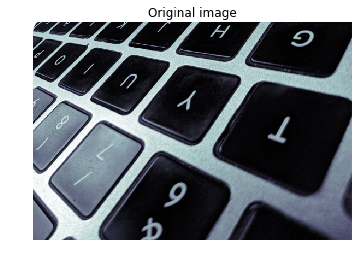

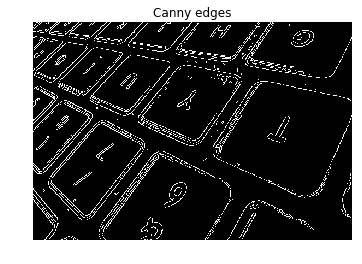

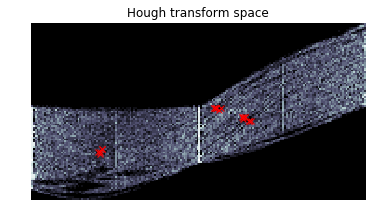

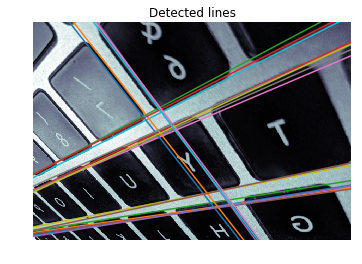

In [10]:

#DEMO CELL
# Logistic sigmoid function
def sigm(x):
    return 1 / (1 + np.exp(-x))


# This demo detects the Canny edges for the input image,
# calculates the Hough transform for the Canny edge image,
# displays the Hough votes in an acculumator array
# and finally draws the detected lines

# Read image
I = cv2.imread('board.png', 0)
r, c = I.shape

plt.figure(1)
plt.imshow(I, cmap='bone')
plt.title('Original image')
plt.axis('off')
# Find Canny edges. The input image for cv2.HoughLines should be
# a binary image, so a Canny edge image will do just fine.
# The Canny edge detector uses hysteresis thresholding, where
# there are two different threshold levels.
edges = cv2.Canny(I, 80, 130)
plt.figure(2)
plt.imshow(edges, cmap='gray')
plt.title('Canny edges')
plt.axis('off')
# Compute the Hough transform for the binary image returned by cv2.Canny
# cv2.HoughLines returns 2-element vectors containing (rho, theta)
# cv2.HoughLines(input image, radius resolution(pixels), angular resolution (radians),treshold )
H = cv2.HoughLines(edges, 0.5, np.pi/180, 5)

# Display the transform
theta = H[:,0,1].ravel()
rho = H[:,0,0].ravel()

# Create an acculumator array and the bin coordinates for voting
x_coord = np.arange(0, np.pi, np.pi/180)
y_coord = np.arange(np.amin(rho), np.amax(rho)+1, (np.amax(rho)+1)/50)

acc = np.zeros([np.size(y_coord),np.size(x_coord)])

# Perform the voting
for i in range(np.size(theta)):
    x_id = np.argmin(np.abs(x_coord-theta[i]))
    y_id = np.argmin(np.abs(y_coord-rho[i]))
    acc[y_id, x_id] +=  1

# Pass the values through a logistic sigmoid function and normalize
# (only for the purpose of better visualization)
#acc = sigm(acc)
acc /= np.amax(acc)

plt.figure(3)
plt.imshow(acc,cmap='bone')
plt.axis('off')

plt.title('Hough transform space')

# Compute the Hough transform with higher threshold 
# for displaying ~30 strongest peaks in the transform space
H2 = cv2.HoughLines(edges, 1, np.pi/180, 150)

x2 = H2[:,:,1].ravel()
y2 = H2[:,:,0].ravel()

# Superimpose a plot on the image of the transform that identifies the peaks
plt.figure(3)
for i in range(np.size(x2)):
    x_id = np.argmin(abs(x_coord-x2[i]))
    y_id = np.argmin(abs(y_coord-y2[i]))
    plt.plot(x_id, y_id, 'xr','Linewidth',0.1)
    
# Visualize detected lines on top of the Canny edges.
plt.figure(4)
plt.imshow(I, cmap='bone')
plt.title('Detected lines')
plt.axis('off')


for ind in range(0,len(H2)):
    line=H2[ind,0,:]
    rho=line[0]
    theta=line[1]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))

    plt.plot((x1,x2),(y1,y2))
    
#plt.plot(xk, yk, 'm-')
plt.xlim([0,np.size(I,1)])
plt.ylim([0,np.size(I,0)])
plt.show()
